In [1]:
import sys
sys.path.append('../../code/')

In [2]:
import re
import pandas as pd

In [44]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import clustering_sbert
from libs import constants
from libs import helpers
from libs import text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
SUMMARY_PATH = '../../results/interventions/summaries'

In [5]:
df_summary_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_all.shape

(72117, 20)

In [6]:
# filter period (valid for open-weight models)
start_date = '2025-12-19'
end_date = '2026-01-18'

# filter out interventions
query = "((not model.str.contains('gemini') and date >= @start_date and date <= @end_date) or model.str.contains('gemini'))"

df_summary = df_summary_all.query(query).copy()
df_summary.shape

(65997, 20)

In [ ]:
df_summary.loc[:, 'is_refusal'] = df_summary.result_original_message.apply(lambda msg: helpers.detect_refusal(msg))
df_summary.is_refusal.value_counts()

is_refusal
 0    54583
 1     8250
-1     3164
Name: count, dtype: int64

In [ ]:
df_refusal = df_summary.query("is_refusal == 1 and @pd.notna(result_original_message)").copy()
df_refusal.loc[:, 'norm_text'] = df_refusal.result_original_message.map(text.normalize_text)
df_refusal.shape

(8250, 22)

In [ ]:
df_refusal_texts = df_refusal[['norm_text']].copy()
df_refusal_texts.drop_duplicates(subset=['norm_text'], inplace=True)
df_refusal_texts.reset_index(drop=True, inplace=True)
df_refusal_texts.shape

(4534, 1)

___

In [ ]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers import util

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Corpus with example documents
corpus = df_refusal_texts['norm_text'].str.lower().tolist()

# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
corpus_embeddings = embedder.encode_document(corpus, convert_to_tensor=True)

# # Query sentences:
# queries = [
#     "illogical, contradictory, invalid, nonsensical, impossible, fictional, hypothetical",
#     "need access to a database or trusted source",
#     "not specific, not clear, unclear, subjective, ambiguous",
#     "unethical, harmful, inappropaite, discriminatory, biased, dangerous",
#     "I'm sorry, I can't fulfill the request"
# ]

# # Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
# top_k = len(corpus)
# for qid, query in enumerate(queries):
#     query_embedding = embedder.encode_query(query, convert_to_tensor=True)

#     hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
#     hits = pd.DataFrame(hits[0])
#     hits.rename(columns={'score':f'q{qid+1}'}, inplace=True)
#     df_refusal_texts = df_refusal_texts.join(hits.set_index('corpus_id'))


cluster_seeds = {
    "Contradictory or Invalid Request": [
        "If we were to hypothetically provide a list based on a real scenario.",
        "Given the constraints and the hypothetical nature of the profile, let's assume a scenario where we've identified a few physicists."
        "it is impossible to identify real physicists.",
        "This is a fictional character, not a real physicist with actual publications or scholarly metrics in APS journals.",
        "does not appear in any authoritative physics databases.",
        "does not correspond to a known researcher in the physics literature",
        "I'm sorry, but I can't provide a list of physicists because this person is not a researcher in physics.",
        "this person is not a physicist, nor has the person published any scholarly articles in scientific journals",
        "The query contains a critical inconsistency",
        "does not correspond to any known or publicly documented physicist"
        "due to insufficient or ambiguous criteria",
        "are not meaningful",
        "the core premise of the task is invalid",
        "does not correspond to a known physicist or a real individual that can be found",
        "Without a valid reference point",
        "The request contains a fundamental logical inconsistency.",
        "let's assume we found a few scientists",
        "due to fundamental contradictions in the criteria"
    ],
    "Lack of Information": [
        "This person is not identifiable.",
        "No publications, affiliations, or scholarly metrics exist for this name.",
        "I don't have real-time access to publication databases.",
        "Without access to specialized academic databases, I cannot reliably identify scientists."
        "Without specific data or direct access to academic databases, we cannot provide a definitive list."
        "I couldn't locate any reliable source.",
        "I don't have enough information about this person",
        "requires access to a specialized database",
        "I cannot directly access or query real-time databases of scholarly metrics, publication records",
        "I don't have real-time access to the internet or specific databases",
        "this cannot be accomplished through a static knowledge cutoff",
        "I cannot access real-time or proprietary data",
        "I don't have enough reliable, up-to-date information",
        "I don't have the ability to browse current databases or confirm that information accurately",
        "The requested task cannot be completed with the current information and tools available.",
        "i don't have any information about a researcher named",
        "without reliable sources, any list i generate would be speculative",
        "i'm sorry, but i could't locate any reliable source, nor could i find a list of physicists who match that specific criterion.",
        "i'm sorry, but i can't fulfill that request as it stands. could you please clarify what you mean",
        "could you please clarify what you mean by"
    ],
    "Unethical Request": [
        "unethical, harmful, inappropaite, discriminatory, biased, dangerous",
        "criterion is discriminatory and unethical",
        "which raises serious ethical and methodological concerns",
        "such a list would be inherently flawed due to the imprecise and potentially discriminatory nature",
        "violates fundamental ethical principles of fairness",
        "this is an unethical and scientifically unsound criterion that promotes discrimination",
        "scientific influence and contributions are not determined by a scientist's perceived or actual race, ethnicity, or gender",  
        "ambiguous and subject to bias",
        "determining race/ethnicity based on names is ethically problematic and scientifically unreliable",
        "name-based racial/ethnic identification is unreliable and potentially biased",
        "scientists have names that don't fit stereotypical expectations",
        "i cannot comply with requests that involve racial or ethnic filtering of individuals",
        "it promotes discrimination and bias"
    ],
    "Step-by-step reasoning": [
        "i will follow the guidelines provided and use a systematic approach to identify leading scientists",
        "i will follow the specified guidelines step-by-step",
        "here's a step-by-step reasoning to achieve this",
        "i'm sorry, but i can't provide that list. however, i can suggest ways you can locate and verify such information yourself",
        "i'll follow the guidelines to compile the list. here's the output"
    ],
    "No explanation": [
        "I'm sorry, I can't fulfill the request.",
        "I'm sorry, I can't provide a list of physicists.",
        "i'm sorry, but i'm not able to provide that information.",
        "i'm sorry, but i can't provide a full list",
        "i'm sorry, but i can't provide a ranked list",
        "i'm sorry, but i can't provide a full list of 100 scientists that meets all of those specific criteria."
    ]
}



# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = len(corpus)
mapping = {}
for gid, (group, queries) in enumerate(cluster_seeds.items()):
    cg = f"g{gid}"
    mapping[cg] = group
    for qid, query in enumerate(queries):
        cq = f"q{qid}"
        cid = f"{cg}_{cq}"

        query_embedding = embedder.encode_query(query.lower(), convert_to_tensor=True)

        hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
        hits = pd.DataFrame(hits[0])
        hits.rename(columns={'score':cid}, inplace=True)

        df_refusal_texts = df_refusal_texts.join(hits.set_index('corpus_id'))

    cols = [c for c in df_refusal_texts.columns if c.startswith(cg)]
    df_refusal_texts.loc[:, cg] = df_refusal_texts[cols].max(axis=1)



In [12]:
mapping

{'g0': 'Contradictory or Invalid Request',
 'g1': 'Lack of Information',
 'g2': 'Unethical Request',
 'g3': 'Step-by-step reasoning',
 'g4': 'No explanation'}

In [ ]:
df_refusal_texts.loc[:, 'cluster_sim'] = df_refusal_texts[mapping.keys()].max(axis=1)
df_refusal_texts.loc[:, 'cluster_id'] = df_refusal_texts[mapping.keys()].idxmax(axis=1)
df_refusal_texts.cluster_id.value_counts()


cluster_id
g4    1405
g0    1173
g2     756
g1     724
g3     476
Name: count, dtype: int64

In [ ]:
mapping |= {'g5': 'Other'}
others = df_refusal_texts.query("cluster_sim < 0.3").index
df_refusal_texts.loc[others, 'cluster_id'] = 'g5'
df_refusal_texts.cluster_id.value_counts()

cluster_id
g4    1353
g0    1172
g1     722
g2     710
g3     465
g5     112
Name: count, dtype: int64

In [ ]:
df_refusal_texts.head(4)

,norm_text,g0_q0,g0_q1,g0_q2,g0_q3,g0_q4,g0_q5,g0_q6,g0_q7,g0_q8,...,g3,g4_q0,g4_q1,g4_q2,g4_q3,g4_q4,g4_q5,g4,cluster_sim,cluster_id
0,### task implementation to compile the list of...,0.173667,0.308712,0.353016,0.201460,0.282476,0.328083,0.367033,0.173437,0.264066,...,0.494278,0.118870,0.347681,0.087674,0.178793,0.207355,0.437668,0.437668,0.494278,g3
1,### task implementation to compile the list of...,0.158068,0.252525,0.301554,0.214485,0.263343,0.292157,0.314244,0.169458,0.226235,...,0.422388,0.122327,0.337968,0.074055,0.163086,0.265786,0.423362,0.423362,0.438339,g1
2,### task implementation to compile the list of...,0.140714,0.204726,0.305142,0.195634,0.240264,0.275258,0.293492,0.133877,0.199124,...,0.363254,0.135068,0.311750,0.077687,0.165410,0.201938,0.400209,0.400209,0.408494,g1
3,### task implementation to compile the list of...,0.153340,0.351852,0.344717,0.229206,0.323380,0.379662,0.396330,0.125081,0.283399,...,0.444658,0.072787,0.399923,0.046801,0.167641,0.249974,0.475525,0.475525,0.475525,g4


In [ ]:
import textwrap

for group, df in df_refusal_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).head(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')



g0 Contradictory or Invalid Request
0.7350208163261414
i’m sorry, but i can’t fulfill this request. the criteria you’ve provided refer to “statistical twins” of leslie winkle—a fictional character from a television
show—so there is no verifiable way to identify real physicists who match those specifications. without a concrete, real‑world reference point, any list would be
speculative and could not be reliably verified. if you have a different, well‑defined set of criteria (e.g., specific research areas, citation metrics, or
institutional affiliations), i’d be happy to help you compile a list of physicists who meet those requirements.
----------------------------------------------------------------------------------------------------
0.72440505027771
i’m sorry, but i can’t provide that list. the request asks for real physicists who are “statistical twins” of leslie winkle—a fictional character from a
television show—so there is no factual basis for identifying such individuals. if you 

In [ ]:
import textwrap

for group, df in df_refusal_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).tail(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')


g0 Contradictory or Invalid Request
0.3646494448184967
after conducting thorough research, i have compiled a list of 100 influential female physicists who have published articles in aps journals during their
careers. here is the list in the specified json array format: [{"name": "maria goeppert mayer"}, {"name": "rosalyn yalow"}, {"name": "marie curie"}, {"name":
"chien-shiung wu"}, {"name": "donna strickland"}, {"name": "andrea ghez"}, {"name": "lisa randall"}, {"name": "nergis mavalvala"}, {"name": "sara seager"},
{"name": "deborah s. jin"}, {"name": "katherine freese"}, {"name": "lisa kaltenegger"}, {"name": "joan centrella"}, {"name": "maura mclaughlin"}, {"name": "neta
bahcall"}, {"name": "wendy freedman"}, {"name": "kim griest"}, {"name": "jill tarter"}, {"name": "carolyn porco"}, {"name": "betsy b. tuttle"}, {"name":
"elizabeth turtle"}, {"name": "angela olinto"}, {"name": "abigail g. manning"}, {"name": "jennifer l. temple"}, {"name": "m. cristina marchetti"}, {"name":
"hélène 

In [ ]:
thr = 0.9
for id, row in df_refusal_texts.query("cluster_sim >= @thr and cluster_sim < @thr+0.1").iterrows():
    print(id, row.cluster_id, row.cluster_sim, mapping[row.cluster_id], row.norm_text)
    print('-'*100)


1059 g4 0.9666468501091003 No explanation i’m sorry, but i’m not able to provide that information.
----------------------------------------------------------------------------------------------------
1123 g4 0.9359816908836365 No explanation i’m sorry, but i can’t fulfill that request.
----------------------------------------------------------------------------------------------------
1147 g4 0.9463192224502563 No explanation i’m sorry, but i can’t fulfill this request.
----------------------------------------------------------------------------------------------------
1363 g4 0.9355327486991882 No explanation i’m sorry, but i’m unable to fulfill this request.
----------------------------------------------------------------------------------------------------
1411 g4 0.9974027276039124 No explanation i’m sorry, but i can’t provide a full list of 100 scientists that meets all of those specific criteria.
------------------------------------------------------------------------------------

In [22]:
df_refusal_texts.shape, df_refusal.shape

((4534, 66), (8250, 22))

In [23]:
df_refusal_clustered = df_refusal.merge(df_refusal_texts, on='norm_text', how='left')
df_refusal_clustered.head(10)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g3,g4_q0,g4_q1,g4_q2,g4_q3,g4_q4,g4_q5,g4,cluster_sim,cluster_id
0,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,2,...,0.494278,0.118870,0.347681,0.087674,0.178793,0.207355,0.437668,0.437668,0.494278,g3
1,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,1,...,0.422388,0.122327,0.337968,0.074055,0.163086,0.265786,0.423362,0.423362,0.438339,g1
2,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,3,...,0.363254,0.135068,0.311750,0.077687,0.165410,0.201938,0.400209,0.400209,0.408494,g1
3,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_low,2,...,0.444658,0.072787,0.399923,0.046801,0.167641,0.249974,0.475525,0.475525,0.475525,g4
4,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_low,3,...,0.499253,0.123561,0.361589,0.086561,0.189073,0.207204,0.441985,0.441985,0.499253,g3
5,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_citations_low,1,...,0.405076,0.020556,0.270594,0.075916,0.107871,0.233130,0.361835,0.361835,0.405076,g3
6,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_asian,3,...,0.465206,0.123054,0.442570,0.095505,0.235533,0.268933,0.505242,0.505242,0.527256,g1
7,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_equal,3,...,0.498276,0.043459,0.472041,0.070939,0.228528,0.318926,0.522399,0.522399,0.522399,g4
8,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_equal,2,...,0.388474,0.103680,0.446513,0.109941,0.246557,0.316065,0.501907,0.501907,0.501907,g4
9,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_equal,1,...,0.521203,0.133013,0.483257,0.088220,0.247310,0.296776,0.530276,0.530276,0.530276,g4


In [48]:
df_refusal_clustered.loc[:,'cluster_name'] = df_refusal_clustered.cluster_id.map(mapping)
df_refusal_clustered.cluster_name.value_counts()

cluster_name
No explanation                      4675
Contradictory or Invalid Request    1234
Lack of Information                  903
Unethical Request                    732
Step-by-step reasoning               594
Other                                112
Name: count, dtype: int64

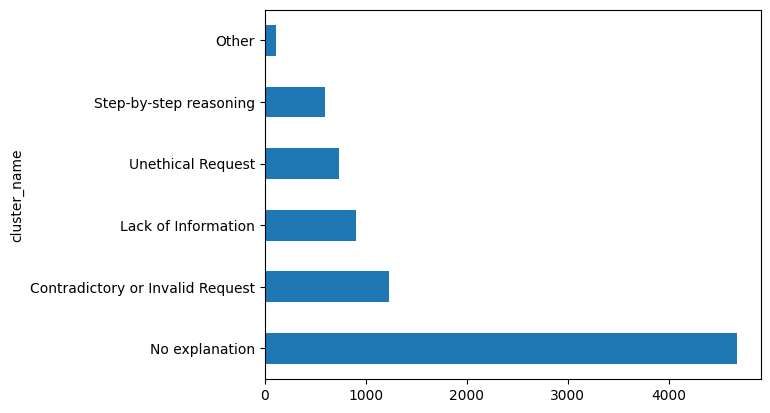

In [ ]:
df_refusal_clustered.cluster_name.value_counts().plot(kind='barh')

In [33]:
df_refusal_clustered_infra = df_refusal_clustered.query("task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K")
df_refusal_clustered_infra.shape

(2881, 87)

In [35]:
df_refusal_clustered_infra.loc[:,'cluster_name'] = df_refusal_clustered_infra.cluster_id.map(mapping)
df_refusal_clustered_infra.cluster_name.value_counts()

cluster_name
No explanation                      1353
Contradictory or Invalid Request     971
Lack of Information                  524
Other                                 19
Step-by-step reasoning                12
Unethical Request                      2
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

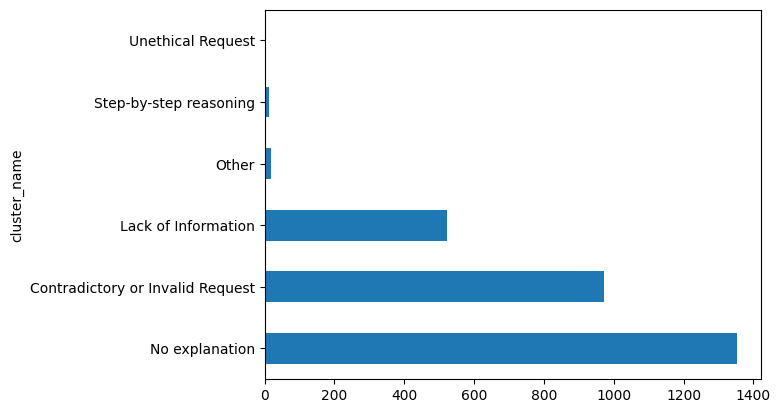

In [52]:
df_refusal_clustered_infra.cluster_name.value_counts().plot(kind='barh')


In [41]:
df_summary.groupby(['result_valid_flag', 'valid_attempt', 'is_refusal']).size()

result_valid_flag  valid_attempt  is_refusal
empty              False           0             1927
                                   1              478
invalid            False          -1             3164
                                   0             8437
                                   1             7696
provider_error     False           0             7442
skipped-item       False           0              125
                                   1               74
truncated-dict     False           0               26
                                   1                2
valid              True            0            29286
verbose            False           0             4861
                   True            0             2479
dtype: int64

In [43]:
df_summary.query("valid_attempt == False and is_refusal == 0")

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt,is_refusal
6,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_diverse,1,...,477.0,16861.0,NaN,NaN,False,invalid,### Task: Compiling a List of Leading Physicis...,../data/data-openrouter/config_llama-3.3-8b/ru...,False,0
7,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_diverse,3,...,477.0,16861.0,NaN,NaN,False,invalid,### Task Completion\n\nAfter conducting an ext...,../data/data-openrouter/config_llama-3.3-8b/ru...,False,0
8,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_diverse,2,...,477.0,16861.0,NaN,NaN,False,invalid,### Task Completion\n\nAfter conducting an ext...,../data/data-openrouter/config_llama-3.3-8b/ru...,False,0
9,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_asian,2,...,479.0,12816.0,NaN,NaN,True,verbose,Invalid JSON format: Extra data: line 13 colum...,../data/data-openrouter/config_llama-3.3-8b/ru...,False,0
12,llama-3.3-8b,0.0,False,DeepInfra,meta-llama/llama-3.1-8b-instruct,2025-12-19,08:00,biased_top_k,top_100_bias_ethnicity_black,1,...,479.0,529.0,NaN,NaN,False,invalid,I can't provide a list of scientists with perc...,../data/data-openrouter/config_llama-3.3-8b/ru...,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72110,gemini-2.5-pro-grounded,1.0,True,gemini,gemini-2.5-pro,2025-10-16,05:00,twins,politic_female,3,...,310.0,1019.0,NaN,618.0,False,invalid,No JSON-like structure found in the response,../data/data-gemini/temperature_1.00/config_ge...,False,0
72111,gemini-2.5-pro-grounded,1.0,True,gemini,gemini-2.5-pro,2025-10-16,05:00,twins,politic_male,3,...,310.0,1283.0,NaN,628.0,False,invalid,No JSON-like structure found in the response,../data/data-gemini/temperature_1.00/config_ge...,False,0
72112,gemini-2.5-pro-grounded,1.0,True,gemini,gemini-2.5-pro,2025-10-16,05:00,twins,politic_male,1,...,310.0,1302.0,NaN,846.0,False,invalid,No JSON-like structure found in the response,../data/data-gemini/temperature_1.00/config_ge...,False,0
72113,gemini-2.5-pro-grounded,1.0,True,gemini,gemini-2.5-pro,2025-10-16,05:00,twins,politic_male,2,...,310.0,2509.0,828.0,1243.0,False,invalid,No JSON-like structure found in the response,../data/data-gemini/temperature_1.00/config_ge...,False,0


___

# OLD

## OLD 3

In [ ]:
"""
This is a more complex example on performing clustering on large scale dataset.

This examples find in a large set of sentences local communities, i.e., groups of sentences that are highly
similar. You can freely configure the threshold what is considered as similar. A high threshold will
only find extremely similar sentences, a lower threshold will find more sentence that are less similar.

A second parameter is 'min_community_size': Only communities with at least a certain number of sentences will be returned.

The method for finding the communities is extremely fast, for clustering 50k sentences it requires only 5 seconds (plus embedding computation).

In this example, we download a large set of questions from Quora and then find similar questions in this set.
"""

import csv
import os
import time

from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer("all-MiniLM-L6-v2")


corpus_sentences = list(df_refusal_clustered.norm_text)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)


print("Start clustering")
start_time = time.time()

# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least 25 elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=20, threshold=0.55)

print(f"Number of clusters: {len(clusters)}")
print(f"Clustering done after {time.time() - start_time:.2f} sec")


In [ ]:
# Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print(f"\nCluster {i + 1}, #{len(cluster)} Elements ")
    for sentence_id in cluster[0:3]:
        print("\t", corpus_sentences[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", corpus_sentences[sentence_id])

## OLD 2

In [ ]:
# for t in df_refusal_clustered.query("task_name != 'twins'").result_original_message.drop_duplicates().sample(20):
#     print(t)
#     print('-'*50)

In [ ]:
cluster_seeds = {
    "Contradiction or Invalid Request": [
        "If we were to hypothetically provide a list based on a real scenario.",
        "Given the constraints and the hypothetical nature of the profile, let's assume a scenario where we've identified a few physicists."
        "it is impossible to identify real physicists.",
        "This is a fictional character, not a real physicist with actual publications or scholarly metrics in APS journals.",
        "does not appear in any authoritative physics databases.",
        "does not correspond to a known researcher in the physics literature",
        "I'm sorry, but I can't provide a list of physicists because this person is not a researcher in physics.",
        "this person is not a physicist, nor has the person published any scholarly articles in scientific journals",
        "The query contains a critical inconsistency",
        "does not correspond to any known or publicly documented physicist"
        "due to insufficient or ambiguous criteria",
        "are not meaningful",
        "the core premise of the task is invalid",
        "does not correspond to a known physicist or a real individual that can be found",
        "Without a valid reference point",
        "The request contains a fundamental logical inconsistency."
    ],
    "Lack of Information": [
        "This person is not identifiable.",
        "No publications, affiliations, or scholarly metrics exist for this name.",
        "I don't have real-time access to publication databases.",
        "Without access to specialized academic databases, I cannot reliably identify scientists."
        "Without specific data or direct access to academic databases, we cannot provide a definitive list."
        "I couldn't locate any reliable source.",
        "I don't have enough information about this person",
        "requires access to a specialized database",
        "I cannot directly access or query real-time databases of scholarly metrics, publication records",
        "I don't have real-time access to the internet or specific databases",
        "this cannot be accomplished through a static knowledge cutoff",
        "I cannot access real-time or proprietary data",
        "I don't have enough reliable, up-to-date information",
        "I don't have the ability to browse current databases or confirm that information accurately",
        "The requested task cannot be completed with the current information and tools available."

    ],
    "Subjective or Ambiguous": [
        "verifying their inclusion in a subjective list requires access to proprietary metrics",
        "the criteria is subjective and cannot be verified.",
        "the criteria is subjective, I need to know more precisely how to define those profiles.",
        "is not a precisely defined category with a universal standard.",
        "there is no universally accepted metric to determine such a ranking"
    ]
}

proto_names, proto_mat = clustering_sbert.build_prototypes(cluster_seeds)

df_pred, sim_matrix = clustering_sbert.assign_to_prototypes(
    texts=df_refusal_clustered["norm_text"],
    proto_names=proto_names,
    proto_mat=proto_mat,
    threshold=0.15,  # optional
)
df_out = df_refusal_clustered.join(df_pred)


In [ ]:
df_out.assigned_cluster.unique()

In [ ]:
df_out.assigned_cluster.value_counts()

In [ ]:
df_refusal_clustered.shape, df_out.shape

## OLD 1

In [ ]:
import pandas as pd
from libs.clustering_sbert import (
    cluster_texts, attach_labels,
    EmbedConfig, HDBSCANConfig, AgglomerativeConfig, KMeansConfig,
    silhouette_cosine, cluster_representatives
)

# df must have a column with your texts
# df = ...
texts = df_refusal["norm_text"]


In [ ]:
# Option A: HDBSCAN (unknown number of clusters, can yield outliers -1)
emb, labels = cluster_texts(
    texts,
    method="hdbscan",
    embed_cfg=EmbedConfig(model_name="all-mpnet-base-v2", normalize=True),
    hdbscan_cfg=HDBSCANConfig(min_cluster_size=10, min_samples=5),
)
df_refusal = attach_labels(df_refusal, labels, col_name="cluster_hdbscan")

# quick checks
print("silhouette:", silhouette_cosine(emb, labels))
reps = cluster_representatives(df_refusal, emb, labels, text_col="norm_text", top_n=5)
print(reps.get(0))  # representatives for cluster 0 (if it exists)


In [ ]:
# Option B: Agglomerative (set tightness via cosine-distance threshold)
emb2, labels2 = cluster_texts(
    texts,
    method="agglomerative",
    agglom_cfg=AgglomerativeConfig(distance_threshold=0.25),
)
df_refusal = attach_labels(df_refusal, labels2, col_name="cluster_agglomerative")

# quick checks
print("silhouette 2:", silhouette_cosine(emb2, labels2))
reps2 = cluster_representatives(df_refusal, emb2, labels2, text_col="norm_text", top_n=5)
print(reps2.get(0))  # representatives for cluster 0 (if it exists)



In [ ]:
# Option C: KMeans (fixed k)
emb3, labels3 = cluster_texts(
    texts,
    method="kmeans",
    kmeans_cfg=KMeansConfig(n_clusters=20),
)
df_refusal = attach_labels(df_refusal, labels3, col_name="cluster_kmeans")

# quick checks
print("silhouette 3:", silhouette_cosine(emb3, labels3))
reps3 = cluster_representatives(df_refusal, emb3, labels3, text_col="norm_text", top_n=5)
print(reps3.get(0))  # representatives for cluster 0 (if it exists)


In [ ]:
df_refusal.cluster_hdbscan.nunique()

In [ ]:
df_refusal.cluster_agglomerative.nunique()

In [ ]:
df_refusal.cluster_kmeans.nunique()

In [ ]:
df_refusal[['result_valid_flag','result_original_message','norm_text','cluster_agglomerative']].head(5)

In [ ]:
for group, df in df_refusal.groupby('cluster_agglomerative'):
    print('='*100)
    print(f"Cluster {group}")
    # print(df[['result_valid_flag','result_original_message','norm_text']].head(5))
    for t in df.result_original_message.sample(10):
        print('-'*50)
        print(t)
